In this Colab Notebook, we will use [ktrain](https://github.com/amaiya/ktrain) (a lightweight wrapper around Keras) to fine-tune Hindi-BERT model for sentiment analysis task, by using a labelled dataset. 


## Installs and imports



In [2]:
! pip install --upgrade pandas tensorflow_gpu ktrain odfpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 6.0 kB/s 
     |████████████████████████████████| 25.3 MB 1.2 MB/s 
     |████████████████████████████████| 717 kB 70.9 MB/s 
     |████████████████████████████████| 5.8 MB 60.3 MB/s 
     |████████████████████████████████| 438 kB 59.5 MB/s 
     |████████████████████████████████| 1.6 MB 67.2 MB/s 
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 981 kB 39.1 MB/s 
     |████████████████████████████████| 1.2 MB 58.3 MB/s 
     |████████████████████████████████| 263 kB 75.5 MB/s 
     |████████████████████████████████| 2.8 MB 64.2 MB/s 
     |████████████████████████████████| 468 kB 66.9 MB/s 
     |████████████████████████████████| 596 kB 59.0 MB/s 
     |████████████████████████████████| 880 kB 48.0 MB/s 
     |████████████████████████████████| 3.3 MB 59.7 MB/s 
     |████████████████████████

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


**RESTART RUNTIME**

## Load Hindi sentiment analysis dataset & split into train-test sets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd 
import os
os.chdir("/content/drive/MyDrive/The-London-Story/Supervised-NLP-tasks/")

df = pd.read_excel ("HINDI_dataset.ods", engine='odf', names=["review", "sentiment"])
df.head()

,review,sentiment
0,गुमनाम है वतन पर मिटने वाले लोग आतन्कवादियों स...,negative
1,ज़ंजीर बदली जा रही थी मैं समझा था रिहाई हो गयी है,negative
2,यूपी में बड़े स्तर पर दंगे करवा सकती है बीजेपी...,negative
3,अंग्रेजी नहीं आती है इसलिए हिन्दी ट्विट ज्यादा...,negative
4,कश्मीर में हो रहा है जल जिहाद ।,negative


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], random_state=91)

In [4]:
print ("Training sample size:", X_train.size)
print ("Validation dataset size:", X_test.size)


print("Training labels:", set(y_train.values))

Training sample size: 6807
Validation dataset size: 2269
Training labels: {'neutral', 'negative', 'positive'}


N.B. ktrain code below is based on the source code [here](https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed) 

## Create a transformer instance & preprocess the datasets





In [5]:
import ktrain
from ktrain import text
t = text.Transformer("monsoon-nlp/hindi-bert", maxlen=500, class_names=list(set(y_train.values)))

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

In [6]:
trn = t.preprocess_train(X_train.to_numpy(), y_train.to_numpy())

preprocessing train...
language: hi
train sequence lengths:
	mean : 16
	95percentile : 27
	99percentile : 30


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:738: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  "class_names argument was ignored, as they were extracted from string labels in dataset"


Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Is Multi-Label? False


In [7]:
evalr = t.preprocess_test(X_test.to_numpy(), y_test.to_numpy())

preprocessing test...
language: hi
test sequence lengths:
	mean : 16
	95percentile : 27
	99percentile : 30


## Load a classifier model and instantiate a Learner object

We define a classifier with pretrained weights and randomly initialized final layers that can be fine-tuned. The model will be wrapped in a ktrain Learner object that will allow us to easily train and inspect the model and use it to make predictions on new data.

In [8]:
model = t.get_classifier()

Downloading:   0%|          | 0.00/59.1M [00:00<?, ?B/s]

In [10]:
learner = ktrain.get_learner(model, train_data=trn, val_data=evalr, batch_size=6)

## Estimate the Learning Rate or LR - (optional)

We use the Learning Rate Finder in *ktrain* to estimate a good learning rate for our model and dataset.
For BERT-based models, learning rates between 2e-5 and 5e-5 generally work well across a wide range of datasets. Thus, this step is optional.

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
1134/1134 [==============================] - 231s 185ms/step - loss: 1.0473 - accuracy: 0.4293
Epoch 2/3
1134/1134 [==============================] - 205s 180ms/step - loss: 0.9930 - accuracy: 0.4341
Epoch 3/3
1134/1134 [==============================] - 74s 65ms/step - loss: 141.0084 - accuracy: 0.3579


done.
Visually inspect loss plot and select learning rate associated with falling loss


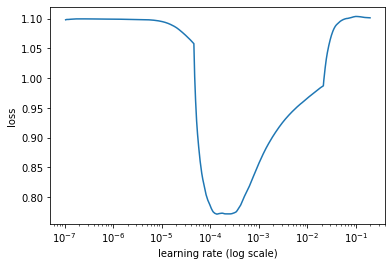

In [11]:
learner.lr_find(show_plot=True, max_epochs=3)

If you pick a bad learning rate below, learner will remember the bad training. I've purposely included the `model =` and `learner =` lines in the cell below to reset.

## Train the model

In [12]:
model = t.get_classifier()
learner = ktrain.get_learner (model, train_data=trn, val_data=evalr, batch_size=6)
learner.fit_onecycle(1.2e-4, 3)



begin training using onecycle policy with max lr of 0.00012...
Epoch 1/3
1135/1135 [==============================] - 224s 183ms/step - loss: 0.8078 - accuracy: 0.5809 - val_loss: 0.6509 - val_accuracy: 0.6311
Epoch 2/3
1135/1135 [==============================] - 204s 179ms/step - loss: 0.6441 - accuracy: 0.6667 - val_loss: 0.5560 - val_accuracy: 0.7616
Epoch 3/3
1135/1135 [==============================] - 206s 180ms/step - loss: 0.5000 - accuracy: 0.7954 - val_loss: 0.5052 - val_accuracy: 0.7924


## Inspect and evaluate the model

Invoke `view_top_losses` to view the most misclassified review in the validation set

In [13]:
learner.view_top_losses(n=5, preproc=t)

71/71 [==============================] - 7s 56ms/step
----------
id:1118 | loss:6.1 | true:neutral | pred:negative)

----------
id:1595 | loss:5.88 | true:neutral | pred:negative)

----------
id:346 | loss:5.81 | true:neutral | pred:negative)

----------
id:216 | loss:5.19 | true:neutral | pred:positive)

----------
id:1608 | loss:4.96 | true:neutral | pred:negative)



In [14]:
val = learner.validate(evalr, class_names=list(set(y_train.values)))

71/71 [==============================] - 4s 56ms/step
              precision    recall  f1-score   support

     neutral       0.78      0.69      0.73       803
    negative       0.91      0.94      0.93       665
    positive       0.71      0.77      0.74       801

    accuracy                           0.79      2269
   macro avg       0.80      0.80      0.80      2269
weighted avg       0.79      0.79      0.79      2269



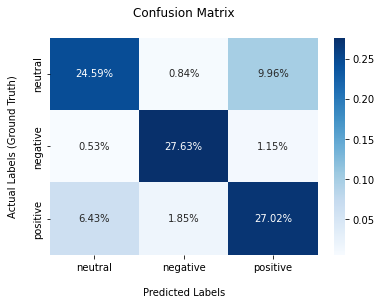

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

ax = sns.heatmap(val/np.sum(val), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Labels')
ax.set_ylabel('Actual Labels (Ground Truth)\n');

## Ticket labels
ax.xaxis.set_ticklabels(list(set(y_train.values)))
ax.yaxis.set_ticklabels(list(set(y_train.values)))

## Display the visualization of the Confusion Matrix.
plt.show()

## Make Predictions on New Data

In [23]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [24]:
predictor.predict("चीन के सामने भारत के जांबाज़ सूरमाओं की Exclusive रिपोर्ट कोल्ड डेजर्ट के नाम से मशहूर नेलांग वैली से।… https://t.co/7JBdsL6xaE")

1/1 [==============================] - 0s 86ms/step


'positive'

## Explain predictions (Explainable AI)

In [25]:
!pip3 install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/amaiya/eli5 (to revision tfkeras_0_10_1) to /tmp/pip-req-build-2n5xl0w9
  Running command git clone -q https://github.com/amaiya/eli5 /tmp/pip-req-build-2n5xl0w9
  Running command git checkout -b tfkeras_0_10_1 --track origin/tfkeras_0_10_1
  Switched to a new branch 'tfkeras_0_10_1'
  Branch 'tfkeras_0_10_1' set up to track remote branch 'tfkeras_0_10_1' from 'origin'.
  Created wheel for eli5: filename=eli5-0.10.1-py2.py3-none-any.whl size=106895 sha256=47d6abd3f391cbf3ad9d3e2eb4b042688fd29829d75aee3310150c101aefb54e
  Stored in directory: /tmp/pip-ephem-wheel-cache-tx3y76jf/wheels/f8/8c/47/b4cafd3c9519194a489dd614ead1485899d2b34c5adc4198ff
Successfully built eli5


The visualization below is generated using a technique called [LIME](https://arxiv.org/abs/1602.04938). The input is randomly perturbed to examine how the prediction changes. This is used to infer the relative importance of different words to the final prediction using a linear interpretable model.
The GREEN words contribute to the model prediction. 
The RED (and PINK) words detract from the model prediction (Shade of color denotes the strength or size of the coefficients in the inferred linear model).

In [26]:
predictor.explain("चीन के सामने भारत के जांबाज़ सूरमाओं की Exclusive रिपोर्ट कोल्ड डेजर्ट के नाम से मशहूर नेलांग वैली से।… https://t.co/7JBdsL6xaE")

79/79 [==============================] - 7s 84ms/step


In [27]:
predictor.predict_proba ("चीन के सामने भारत के जांबाज़ सूरमाओं की Exclusive रिपोर्ट कोल्ड डेजर्ट के नाम से मशहूर नेलांग वैली से।… https://t.co/7JBdsL6xaE")

1/1 [==============================] - 0s 76ms/step


array([0.16490684, 0.01411931, 0.8209738 ], dtype=float32)

In [28]:
predictor.get_classes()

['negative', 'neutral', 'positive']

## Save and reload the predictor

In [29]:
predictor.save('/content/drive/MyDrive/Models/hindi_sentiment_predictor')

In [30]:
reloaded_predictor = ktrain.load_predictor ('/content/drive/MyDrive/Models/hindi_sentiment_predictor')

Test whether the reloaded predictor works

In [31]:
reloaded_predictor.explain("चीन के सामने भारत के जांबाज़ सूरमाओं की Exclusive रिपोर्ट कोल्ड डेजर्ट के नाम से मशहूर नेलांग वैली से।… https://t.co/7JBdsL6xaE")

79/79 [==============================] - 5s 64ms/step
